(rv)=

# Radial velocity fitting

In [1]:
import sys
sys.version

'3.9.5 | packaged by conda-forge | (default, Jun 19 2021, 00:27:35) \n[Clang 11.1.0 ]'

In [2]:
import exoplanet
print(f"exoplanet.__version__ = '{exoplanet.__version__}'")

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


exoplanet.__version__ = '0.5.1'


Fitting RVs for Earth and Jupiter

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx
from astropy import units as u
from astropy.constants import M_earth, M_sun
from simulate_data import *

import matplotlib 
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18)


# orbital parameters from https://www.princeton.edu/~willman/planetary_systems/Sol/
# BJD determined by converting values above using https://ssd.jpl.nasa.gov/tc.cgi#top

P_earth = 365.256
e_earth = 0.0167
Tper_earth= 2454115.5208333
omega_earth = np.radians(102.9)
Omega_earth = np.radians(0.0)
inclination_earth = np.radians(45.0)
m_earth = 1 #units m_earth



P_jup = 4327.631
e_jup = 0.0484
Tper_jup = 2455633.7215278
omega_jup = np.radians(274.3)
Omega_jup = np.radians(100.4)
inclination_jup = np.radians(1.304) + inclination_earth
m_jup = 317.83 #units m_earth


P_nep = 59758.97 
e_nep = 0.00859
Tper_nep = 2468662.5000000
omega_nep = np.radians(273.2)
Omega_nep = np.radians(131.784)
inclination_nep = np.radians(1.7700) + inclination_earth
m_nep = 17.204 #units m_earth5.9724



P_saturn = 10739.58 
e_saturn = 0.0539
Tper_saturn = 2452832.0625000
omega_saturn = np.radians(338.9)
Omega_saturn = np.radians(113.7)
inclination_saturn = np.radians(2.486) + inclination_earth
m_saturn = 95.159 #units m_earth




M_earth   Name   = Earth mass
  Value  = 5.972167867791379e+24
  Uncertainty  = 1.3422009501651213e+20
  Unit  = kg
  Reference = IAU 2015 Resolution B 3 + CODATA 2018


/Users/Danielyahalomi/Documents/Columbia/Research/RomanAstrometry/Code/simulate_data.py:291: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/Danielyahalomi/Documents/Columbia/Research/RomanAstrometry/Code/simulate_data.py:359: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


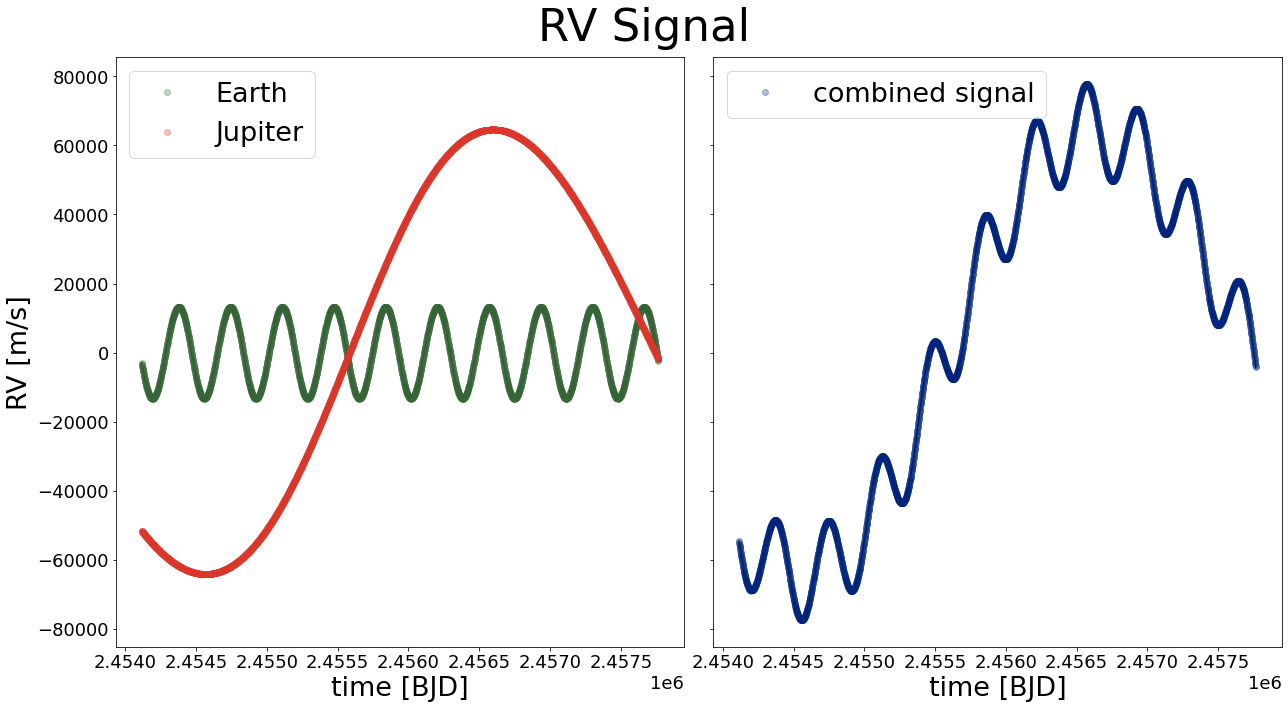

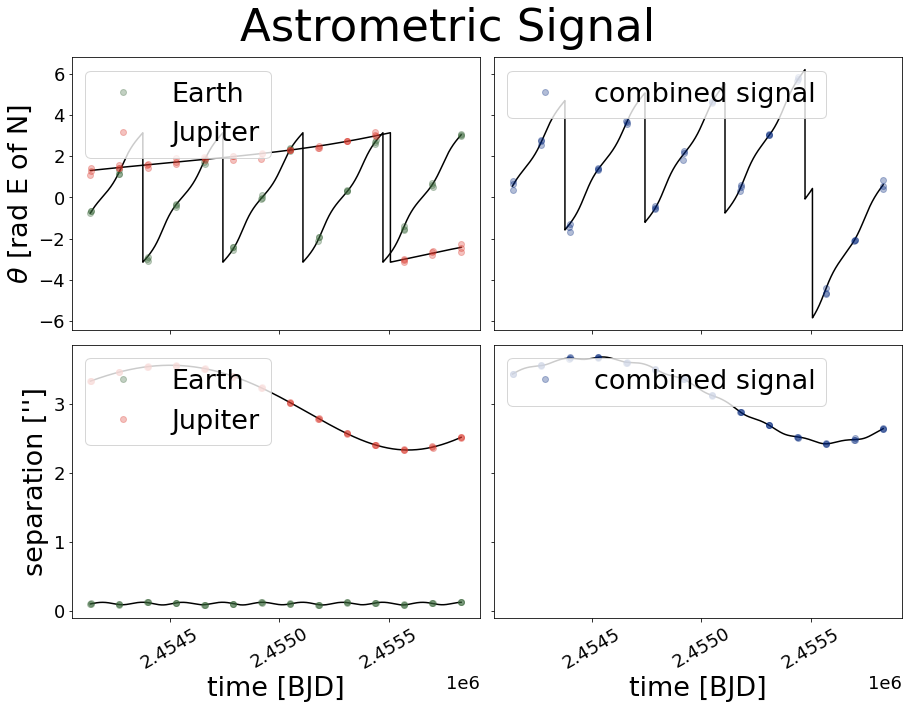

In [4]:
orbit_params_earth = [P_earth, e_earth, Tper_earth, omega_earth, Omega_earth, inclination_earth, m_earth]
orbit_params_jup = [P_jup, e_jup, Tper_jup, omega_jup, Omega_jup, inclination_jup, m_jup]
orbit_params_saturn = [P_saturn, e_saturn, Tper_saturn, omega_saturn, Omega_saturn, inclination_saturn, m_saturn]
orbit_params_nep = [P_nep, e_nep, Tper_nep, omega_nep, Omega_nep, inclination_nep, m_nep]

orbit_params = [orbit_params_earth, orbit_params_jup]

times_observed_astrometry = []
t_0 = int(Tper_earth)
for ii in range(t_0, t_0+1825):
    if ii % 130 == 0:
        times_observed_astrometry.append(ii-1)
        times_observed_astrometry.append(ii)
        times_observed_astrometry.append(ii+1)

n_planets = 2
t_dur_rv = 3650
n_obs_rv = 3000
sigma_rv = 0.01

sigma_theta = 0.1
sigma_rho = 0.005
plx = 0.1


simulate_and_plot(
    n_planets, 
    sigma_rv, 
    sigma_theta,
    sigma_rho,
    plx,
    orbit_params,
    ['#366537', '#db372b', '#00257c'],
    ['Earth', 'Jupiter'],
    t_dur_rv = t_dur_rv,
    n_obs_rv = n_obs_rv,
    times_observed_astrometry = times_observed_astrometry
    )



<ErrorbarContainer object of 3 artists>

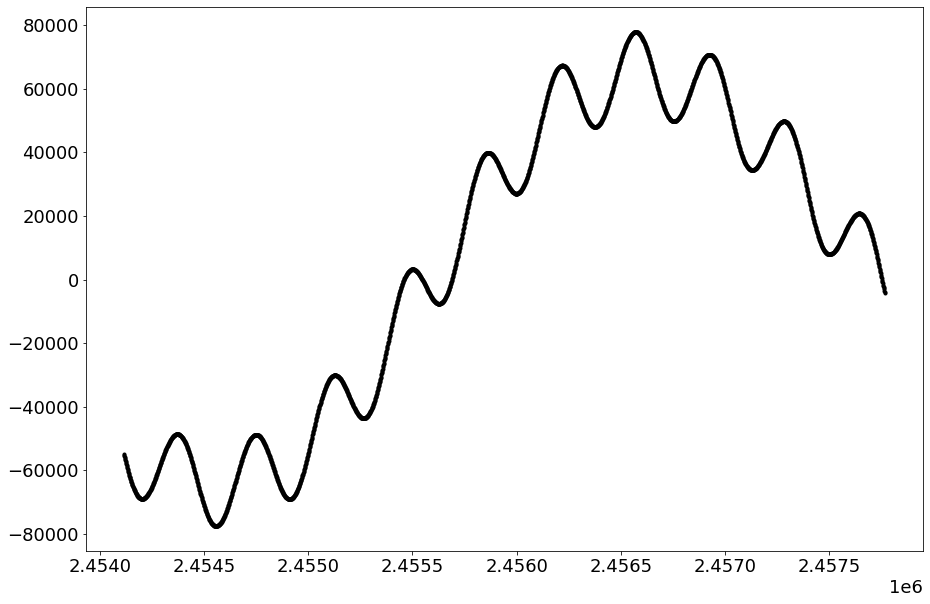

In [4]:
times, rv_results, theta_results, rho_results = simulate_data(
    n_planets, 
    sigma_rv, 
    sigma_theta,
    sigma_rho,
    plx,
    orbit_params,
    t_dur_rv = t_dur_rv,
    n_obs_rv = n_obs_rv,
    times_observed_astrometry = times_observed_astrometry
    )


[[times_rv, times_observed_rv, times_astrometry, times_observed_astrometry],
     [rv_orbit, rv_orbit_sum, rv_sim, rv_sim_sum],
     [theta_orbit, theta_orbit_sum, theta_sim, theta_sim_sum],
     [rho_orbit, rho_orbit_sum, rho_sim, rho_sim_sum]]  = times, rv_results, theta_results, rho_results





x_rv = times_observed_rv
y_rv = rv_sim_sum
y_rv_err = np.full(np.shape(y_rv), .01)


# Also make a fine grid that spans the observation window for plotting purposes
t = np.linspace(x_rv.min() - 5, x_rv.max() + 5, 1000)


plt.figure(figsize=[15,10])
plt.errorbar(x_rv,y_rv, yerr=y_rv_err, ls = '', marker = '.', color = 'k')

We will have a sense of the periods of the planets, so we can use the `exoplanet.estimate_semi_amplitude` function to estimate the expected RV semi-amplitudes for the planets.

In [15]:
periods = [365.3, 4327.5]
period_errs = [1, 5]
t0s = [2454115.58958191, 2457740.80985712]
t0_errs = [5, 5]
Ks = xo.estimate_semi_amplitude(periods, x_rv, y_rv, y_rv_err, t0s=t0s)
print(Ks, "m/s")

[12814.70742918 64841.41438153] m/s


In [6]:
0.5 * (
    np.log(np.array(periods) + np.array(period_errs))
    - np.log(np.array(periods) - np.array(period_errs))
)

array([0.00273748, 0.0011554 ])

In [7]:
np.array(period_errs) / np.array(periods)


array([0.00273748, 0.0011554 ])

## The radial velocity model in PyMC3

Now that we have the data and an estimate of the initial values for the parameters, let's start defining the probabilistic model in PyMC3.
First, we'll define our priors on the parameters:

In [8]:
import aesara_theano_fallback.tensor as tt

with pm.Model() as model:
    
    ## Gaussian priors based on previous modeling
    t0 = pm.Normal("t0", mu=np.array(t0s), sd=np.array(t0_errs), shape=2)
    
    #log normal prior on period around estimates
    logP = pm.Normal(
        "logP",
        mu=np.log(periods),
        sd=np.array(period_errs) / np.array(periods),
        shape=2,
        testval=np.log(periods),
    )
    P = pm.Deterministic("P", tt.exp(logP))

    # Wide log-normal prior for semi-amplitude
    logK = pm.Normal("logK", mu=np.log(Ks), sd=2.0, shape=2, testval=np.log(Ks))
    
    K = pm.Deterministic("K", tt.exp(logK))

    # Eccentricity & argument of periasteron
    ecs = pmx.UnitDisk("ecs", shape=(2, 2), testval=0.01 * np.ones((2, 2)))
    ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2, axis=0))
    omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
    
    # Jitter & a quadratic RV trend
    logs = pm.Normal("logs", mu=np.log(np.median(y_rv_err)), sd=0.01)

    # Then we define the orbit
    orbit = xo.orbits.KeplerianOrbit(period=P, t0=t0, ecc=ecc, omega=omega)

    # And a function for computing the full RV model
    def get_rv_model(t, name=""):
        # First the RVs induced by the planets
        vrad = orbit.get_radial_velocity(t, K=tt.exp(logK))
        pm.Deterministic("vrad" + name, vrad)

        # Sum over planets and add the background to get the full model
        return pm.Deterministic("rv_model" + name, tt.sum(vrad, axis=-1))

    # Define the RVs at the observed times
    rv_model = get_rv_model(x_rv)

    # Also define the model on a fine grid as computed above (for plotting)
    rv_model_pred = get_rv_model(t, name="_pred")

    # Finally add in the observation model. This next line adds a new contribution
    # to the log probability of the PyMC3 model
    err = tt.sqrt(y_rv_err ** 2 + tt.exp(2 * logs))
    pm.Normal("obs", mu=rv_model, sd=err, observed=y_rv)

Now, we can plot the initial model:

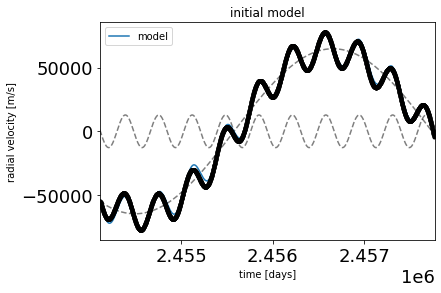

In [9]:
plt.errorbar(x_rv, y_rv, yerr=y_rv_err, fmt=".k")
with model:
    plt.plot(t, pmx.eval_in_model(model.vrad_pred), "--k", alpha=0.5)
    plt.plot(t, pmx.eval_in_model(model.rv_model_pred), label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("initial model")

In this plot, the background is the dotted line, the individual planets are the dashed lines, and the full model is the blue line.

It looks pretty good already, but let's still fit for the maximum a posterior parameters.

In [10]:
with model:
    map_soln = pmx.optimize(start=model.test_point, vars=[t0])
    map_soln = pmx.optimize(start=map_soln, vars=[logK, logP, logs])
    map_soln = pmx.optimize(start=map_soln, vars=[ecs])
    map_soln = pmx.optimize(start=map_soln)

optimizing logp for variables: [t0]


message: Desired error not necessarily achieved due to precision loss.
logp: -67838787218187.97 -> -34172641200933.992
optimizing logp for variables: [logs, logP, logK]


message: Desired error not necessarily achieved due to precision loss.
logp: -34172641200933.992 -> -615081.1744267194
optimizing logp for variables: [ecs]


message: Optimization terminated successfully.
logp: -615081.1744267194 -> -563000.7015169164
optimizing logp for variables: [logs, ecs, logK, logP, t0]


message: Desired error not necessarily achieved due to precision loss.
logp: -563000.7015169164 -> 8559.70142578873


No handles with labels found to put in legend.


[2454102.86072257 2457740.65985748]


Text(0.5, 1.0, 'MAP model only')

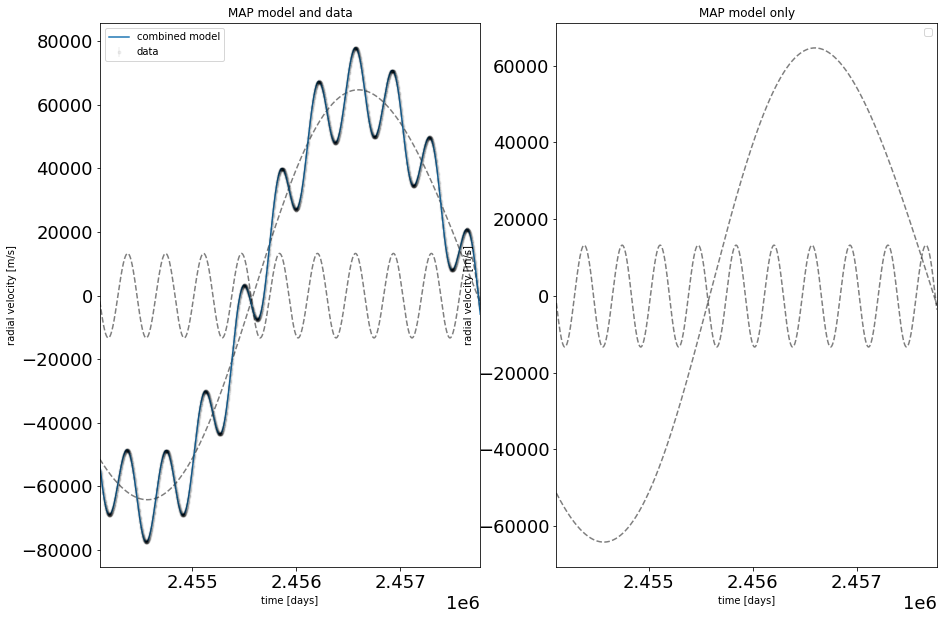

In [11]:
fig, ax = plt.subplots(1,2, figsize = [15,10])
print(map_soln['t0'])

ax[0].errorbar(x_rv, y_rv, yerr=y_rv_err, fmt=".k", alpha = 0.05, label='data')
ax[0].plot(t, map_soln["vrad_pred"], "--k", alpha=0.5)
ax[0].plot(t, map_soln["rv_model_pred"], label="combined model")

ax[0].legend(fontsize=10)
ax[0].set_xlim(t.min(), t.max())
ax[0].set_xlabel("time [days]")
ax[0].set_ylabel("radial velocity [m/s]")
ax[0].set_title("MAP model and data")


ax[1].plot(t, map_soln["vrad_pred"], "--k", alpha=0.5)
ax[1].legend(fontsize=10)
ax[1].set_xlim(t.min(), t.max())
ax[1].set_xlabel("time [days]")
ax[1].set_ylabel("radial velocity [m/s]")
ax[1].set_title("MAP model only")


That looks better.

## Sampling

Now that we have our model set up and a good estimate of the initial parameters, let's start sampling.
There are substantial covariances between some of the parameters so we'll use the `pmx.sample` function from [pymc3-ext](https://github.com/exoplanet-dev/pymc3-ext) which wraps `pm.sample` function with some better defaults and tuning strategies.

In [12]:
np.random.seed(42)
with model:
    trace = pmx.sample(
        tune=1000,
        draws=1000,
        chains=2,
        target_accept=0.9,
        return_inferencedata=True,
    )

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logs, ecs, logK, logP, t0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 44 seconds.
The acceptance probability does not match the target. It is 1.0, but should be close to 0.9. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


After sampling, it's always a good idea to do some convergence checks.
First, let's check the number of effective samples and the Gelman-Rubin statistic for our parameters of interest:

In [13]:
import arviz as az

az.summary(
    trace, var_names=["logs", "omega", "ecc", "t0", "logK", "P"]
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
logs,-4.605,0.0,-4.605,-4.605,0.0,0.0,4.0,2.0,2.0,2.0,NaN
omega[0],0.785,0.0,0.785,0.785,0.0,0.0,2.0,2.0,2.0,2.0,NaN
omega[1],0.785,0.0,0.785,0.785,0.0,0.0,13.0,2.0,2.0,2.0,3.7
ecc[0],0.000,0.0,0.000,0.000,0.0,0.0,2.0,2.0,2.0,2.0,NaN
ecc[1],0.000,0.0,0.000,0.000,0.0,0.0,2.0,2.0,2.0,2.0,3.7
t0[0],2454115.590,0.0,2454115.590,2454115.590,0.0,0.0,2000.0,2000.0,2000.0,2000.0,NaN
t0[1],2457740.810,0.0,2457740.810,2457740.810,0.0,0.0,2000.0,2000.0,2000.0,2000.0,NaN
logK[0],9.458,0.0,9.458,9.458,0.0,0.0,4.0,4.0,2.0,2.0,NaN
logK[1],11.080,0.0,11.080,11.080,0.0,0.0,2.0,2.0,2.0,2.0,NaN
P[0],365.300,0.0,365.300,365.300,0.0,0.0,2.0,2.0,2.0,2.0,NaN


ValueError: cannot convert float NaN to integer

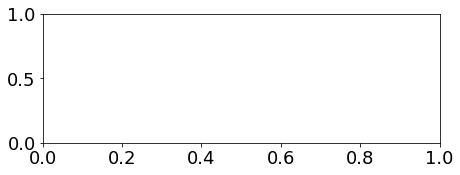

In [14]:
pm.traceplot(trace, var_names=["logs", "P", "logK", "ecc", "omega"])


It looks like everything is pretty much converged here. 

Then we can make a [corner plot](https://corner.readthedocs.io) of any combination of the parameters.
For example, let's look at period, semi-amplitude, and eccentricity:

In [21]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

Finally, let's plot the plosterior constraints on the RV model and compare those to the data:

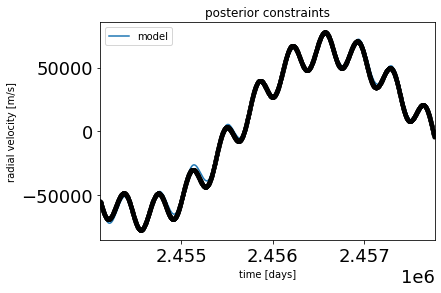

In [22]:
plt.errorbar(x_rv, y_rv, yerr=y_rv_err, fmt=".k")

# Compute the posterior predictions for the RV model
rv_pred = trace.posterior["rv_model_pred"].values
pred = np.percentile(rv_pred, [16, 50, 84], axis=(0, 1))
plt.plot(t, pred[1], color="C0", label="model")
art = plt.fill_between(t, pred[0], pred[2], color="C0", alpha=0.3)
art.set_edgecolor("none")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("posterior constraints")

## Phase plots

It might be also be interesting to look at the phased plots for this system.
Here we'll fold the dataset on the median of posterior period and then overplot the posterior constraint on the folded model orbits.

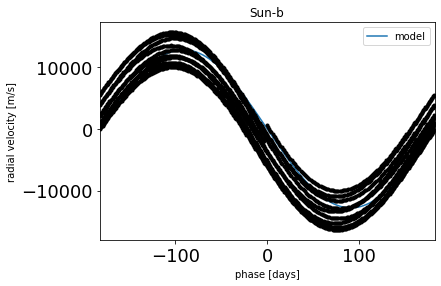

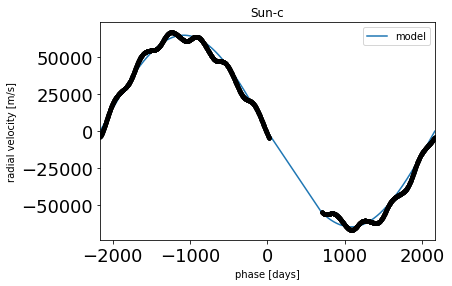

In [23]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace.posterior["P"].values[:, :, n])
    t0 = np.median(trace.posterior["t0"].values[:, :, n])

    # Compute the median of posterior estimate the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(
        trace.posterior["vrad"].values[:, :, :, (n + 1) % 2], axis=(0, 1)
    )

    # Plot the folded data
    x_fold = (x_rv - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(x_fold, y_rv - other, yerr=y_rv_err, fmt=".k")

    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
    inds = np.argsort(t_fold)
    pred = np.percentile(
        trace.posterior["vrad_pred"].values[:, :, inds, n],
        [16, 50, 84],
        axis=(0, 1),
    )
    plt.plot(t_fold[inds], pred[1], color="C0", label="model")
    art = plt.fill_between(
        t_fold[inds], pred[0], pred[2], color="C0", alpha=0.3
    )
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("Sun-{0}".format(letter))

In [ ]:
parameters = ["P", "K", "ecc", "omega", "t0"]
param_medians = {}
posterior1 = {}
posterior2 = {}
for param in parameters:
    posterior1[param]=np.concatenate(trace.posterior[param].values[:, :, 0])
    posterior2[param]=np.concatenate(trace.posterior[param].values[:, :, 1])
    print(posterior1[param])
    
    print(param + " median")
    planet1_med = np.median(trace.posterior[param].values[:, :, 0])
    planet2_med = np.median(trace.posterior[param].values[:, :, 1])
    print(planet1_med)
    print(planet2_med)
    
    param_medians[param]=[planet1_med, planet2_med]
    print("")

In [ ]:
parameters = ["P", "K", "ecc", "omega", "t0"]
for param in parameters:
    fig, ax = plt.subplots(1,2, figsize = (15,5))
    planet1_chain1 = trace.posterior[param].values[:, :, 0][0]
    planet1_chain2 = trace.posterior[param].values[:, :, 0][1]
    
    planet2_chain1 = trace.posterior[param].values[:, :, 1][0]
    planet2_chain2 = trace.posterior[param].values[:, :, 1][1]
    
    
    nstep = np.arange(1, len(chain1)+1, 1)
    
    
    ax[0].plot(nstep, planet1_chain1)
    ax[0].plot(nstep, planet1_chain2)
    ax[0].axhline(y=param_medians[param][0], color = 'k', label = 'median')
    ax[0].set_title("Sun-b", fontsize = 18)
    ax[0].legend(fontsize = 18)
    
    ax[1].plot(nstep, planet2_chain1)
    ax[1].plot(nstep, planet2_chain2)
    ax[1].axhline(y=param_medians[param][1], color = 'k', label = 'median')
    ax[1].set_title("Sun-c", fontsize = 18)
    ax[1].legend(fontsize = 18)

    fig.suptitle(param, fontsize = 18)
    fig.tight_layout()
    plt.show()

In [ ]:
figure = corner.corner(trace,labels=["P", "K", "ecc", "omega", "t0"])

In [ ]:
trace

(astrometric)=

# Astrometric fitting

In [3]:
import exoplanet

#exoplanet.utils.docs_setup()
print(f"exoplanet.__version__ = '{exoplanet.__version__}'")

exoplanet.__version__ = '0.4.0'


In this case study we'll walk through the simplest astrometric example with `exoplanet` and then explain how to build up a more complicated example with parallax measurements. For our dataset, we'll use astrometric and radial velocity observations of a binary star system.

Astrometric observations usually consist of measurements of the separation and position angle of the secondary star (or directly imaged exoplanet), relative to the primary star as a function of time. The simplest astrometric orbit (in terms of number of parameters), describes the orbit using a semi-major axis `a_ang` measured in *arcseconds*, since the distance to the system is assumed to be unknown. We'll work through this example first, then introduce the extra constraints provided by parallax information.

## Data
First, let's load and examine the data. We'll use the astrometric measurements of HR 466 (HD 10009) as compiled by [Pourbaix 1998](https://ui.adsabs.harvard.edu/#abs/1998A&AS..131..377P/abstract). The speckle observations are originally from [Hartkopf et al. 1996](https://ui.adsabs.harvard.edu/#abs/1996AJ....111..370H/abstract).

In [4]:
from astropy.io import ascii
from astropy.time import Time

# grab the formatted data and do some munging
dirname = "https://gist.github.com/iancze/262aba2429cb9aee3fd5b5e1a4582d4d/raw/c5fa5bc39fec90d2cc2e736eed479099e3e598e3/"

astro_data_full = ascii.read(
    dirname + "astro.txt", format="csv", fill_values=[(".", "0")]
)

# convert UT date to JD
astro_dates = Time(astro_data_full["date"].data, format="decimalyear")

# Following the Pourbaix et al. 1998 analysis, we'll limit ourselves to the highest quality data
# since the raw collection of data outside of these ranges has some ambiguities in swapping
# the primary and secondary star
ind = (
    (astro_dates.value > 1975.0)
    & (astro_dates.value < 1999.73)
    & (~astro_data_full["rho"].mask)
    & (~astro_data_full["PA"].mask)
)

astro_data = astro_data_full[ind]

astro_yrs = astro_data["date"]
astro_dates.format = "jd"
astro_jds = astro_dates[ind].value

Many of these measurements in this heterogeneous dataset do not have reported error measurements. For these, we assume a modest uncertainty of $1^\circ$ in position angle and $0.01^{\prime\prime}$ in separation for the sake of specifying something, but we'll include a jitter term for both of these measurements as well. The scatter in points around the final solution will be a decent guide of what the measurement uncertainties actually were.

In [5]:
import numpy as np

astro_data["rho_err"][astro_data["rho_err"].mask == True] = 0.01
astro_data["PA_err"][astro_data["PA_err"].mask == True] = 1.0

# Convert all masked frames to be raw np arrays, since theano has issues with astropy masked columns
rho_data = np.ascontiguousarray(astro_data["rho"], dtype=float)  # arcsec
rho_err = np.ascontiguousarray(astro_data["rho_err"], dtype=float)

# The position angle measurements come in degrees in the range [0, 360].
# We'll convert this to radians in the range [-pi, pi]
deg = np.pi / 180.0
theta_data = np.ascontiguousarray(astro_data["PA"] * deg, dtype=float)
theta_data[theta_data > np.pi] -= 2 * np.pi

theta_err = np.ascontiguousarray(astro_data["PA_err"] * deg)  # radians

## Astrometric conventions

The conventions describing the orientation of the orbits are described in detail in the *exoplanet* paper; we summarize them briefly here. Generally, we follow the conventions from Pourbaix et al. 1998, which are a consistent set conforming to the right-hand-rule and the conventions of the visual binary field, where the ascending node is that where the secondary is *receeding* from the observer (without radial velocity information, there is a $\pi$ degeneracy in which node is ascending, and so common practice in the literature is to report a value in the range $[0,\pi]$). The orbital inclination ranges from $[0, \pi$]. $i = 0$ describes a face-on orbit rotating counter-clockwise on the sky plane, while $i=\pi$ describes a face-on orbit rotating clockwise on the sky. $i = \pi/2$ is an edge-on orbit.

The observer frame $X$, $Y$, $Z$ is oriented on the sky such that $+Z$ points towards the observer, $X$ is the north axis, and $Y$ is the east axis. *All* angles are measured in radians, and the position angle is returned in the range $[-\pi, \pi]$, which is the degrees east of north (be sure to check your data is in this format too!) The radial velocity is still defined such that a positive radial velocity corresponds to motion away from the observer.

In an astrometric-only orbit, it is common practice in the field to report $\omega = \omega_\mathrm{secondary}$, whereas with an RV orbit it is generally common practice to report $\omega = \omega_\mathrm{primary}$. The result is that unless the authors specify what they're using, in a joint astrometric-RV orbit there is an ambiguity to which $\omega$ the authors mean, since $\omega_\mathrm{primary} = \omega_\mathrm{secondary} + \pi$. To standardize this across the *exoplanet* package, in all orbits (including astrometric-only) $\omega = \omega_\mathrm{primary}$.

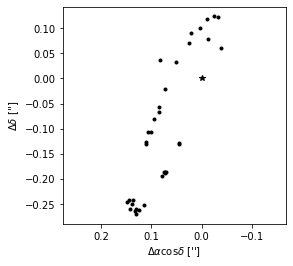

In [6]:
import matplotlib.pyplot as plt

# Make a plot of the astrometric data on the sky
# The convention is that North is up and East is left
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))

xs = rho_data * np.cos(theta_data)  # X is north
ys = rho_data * np.sin(theta_data)  # Y is east
ax.plot(ys, xs, ".k")
ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")

The plot on the sky is helpful to look at, but the "raw" measurements are the values of $\rho$ (separation) and $\theta$ (also called P.A., position angle) that we listed in our data table, and that the measurement uncertainties live on these values as nice Gaussians. So, to visualize this space more clearly, we can plot $\rho$ vs. time and P.A. vs. time.

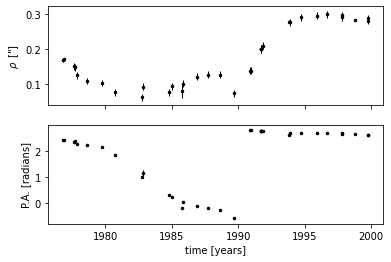

In [7]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].errorbar(astro_yrs, rho_data, yerr=rho_err, fmt=".k", lw=1, ms=5)
ax[0].set_ylabel(r'$\rho\,$ ["]')

ax[1].errorbar(astro_yrs, theta_data, yerr=theta_err, fmt=".k", lw=1, ms=5)
ax[1].set_ylabel(r"P.A. [radians]")
_ = ax[1].set_xlabel("time [years]")

## Fitting the astrometric orbit with *exoplanet*

To get started, let's import the relative packages from *exoplanet*, plot up a preliminary orbit from the literature, and then sample.

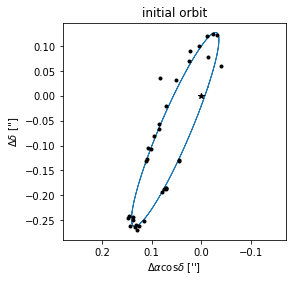

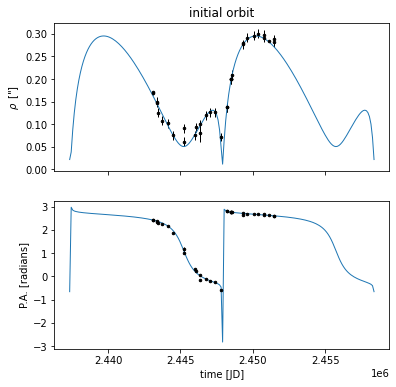

In [8]:
import pymc3 as pm
import pymc3_ext as pmx

from aesara_theano_fallback import aesara as theano
import aesara_theano_fallback.tensor as tt

import exoplanet as xo

from astropy import constants

# conversion constant from au to R_sun
au_to_R_sun = (constants.au / constants.R_sun).value

# Just to get started, let's take a look at the orbit using the parameter estimates from Pourbaix et al. 1998

# Orbital elements from Pourbaix et al. 1998
# For the relative astrometric fit, we only need the following parameters
a_ang = 0.324  # arcsec
parallax = 1  # arcsec (meaningless choice for now)
a = a_ang * au_to_R_sun / parallax
e = 0.798
i = 96.0 * deg  # [rad]
omega = 251.6 * deg - np.pi  # Pourbaix reports omega_2, but we want omega_1
Omega = 159.6 * deg
P = 28.8 * 365.25  # days

T0 = Time(1989.92, format="decimalyear")
T0.format = "jd"
T0 = T0.value  # [Julian Date]

# instantiate the orbit
orbit = xo.orbits.KeplerianOrbit(
    a=a, t_periastron=T0, period=P, incl=i, ecc=e, omega=omega, Omega=Omega
)

# The position functions take an optional argument parallax to convert from
# physical units back to arcseconds
t = np.linspace(T0 - P, T0 + P, num=200)  # days
rho, theta = theano.function([], orbit.get_relative_angles(t, parallax))()

# Plot the orbit
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))

xs = rho * np.cos(theta)  # X is north
ys = rho * np.sin(theta)  # Y is east
ax.plot(ys, xs, color="C0", lw=1)

# plot the data
xs = rho_data * np.cos(theta_data)  # X is north
ys = rho_data * np.sin(theta_data)  # Y is east
ax.plot(ys, xs, ".k")

ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")
ax.set_title("initial orbit")

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax[0].errorbar(astro_jds, rho_data, yerr=rho_err, fmt=".k", lw=1, ms=5)
ax[0].plot(t, rho, color="C0", lw=1)
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[0].set_title("initial orbit")

ax[1].errorbar(astro_jds, theta_data, yerr=theta_err, fmt=".k", lw=1, ms=5)
ax[1].plot(t, theta, color="C0", lw=1)
ax[1].set_ylabel(r"P.A. [radians]")
_ = ax[1].set_xlabel("time [JD]")

Now that we have an initial orbit, we can set the model up using PyMC3 to do inference.

In [9]:
yr = 365.25

# for predicted orbits
t_fine = np.linspace(astro_jds.min() - 500, astro_jds.max() + 500, num=1000)


def get_model(parallax=None):
    with pm.Model() as model:

        if parallax is None:
            # Without an actual parallax measurement, we can model the orbit in units of arcseconds
            # by providing a fake_parallax and conversion constant
            plx = 1  # arcsec
        else:
            # Below we will run a version of this model where a measurement of parallax is provided
            # The measurement is in milliarcsec
            m_plx = pm.Bound(pm.Normal, lower=0, upper=100)(
                "m_plx", mu=parallax[0], sd=parallax[1], testval=parallax[0]
            )
            plx = pm.Deterministic("plx", 1e-3 * m_plx)

        a_ang = pm.Uniform("a_ang", 0.1, 1.0, testval=0.324)
        a = pm.Deterministic("a", a_ang / plx)

        # We expect the period to be somewhere in the range of 25 years,
        # so we'll set a broad prior on logP
        logP = pm.Normal(
            "logP", mu=np.log(25 * yr), sd=10.0, testval=np.log(28.8 * yr)
        )
        P = pm.Deterministic("P", tt.exp(logP))

        # For astrometric-only fits, it's generally better to fit in
        # p = (Omega + omega)/2 and m = (Omega - omega)/2 instead of omega and Omega
        # directly
        omega0 = 251.6 * deg - np.pi
        Omega0 = 159.6 * deg
        p = pmx.Angle("p", testval=0.5 * (Omega0 + omega0))
        m = pmx.Angle("m", testval=0.5 * (Omega0 - omega0))
        omega = pm.Deterministic("omega", p - m)
        Omega = pm.Deterministic("Omega", p + m)

        # For these orbits, it can also be better to fit for a phase angle
        # (relative to a reference time) instead of the time of periasteron
        # passage directly
        phase = pmx.Angle("phase", testval=0.0)
        tperi = pm.Deterministic("tperi", T0 + P * phase / (2 * np.pi))

        # Geometric uiform prior on cos(incl)
        cos_incl = pm.Uniform(
            "cos_incl", lower=-1, upper=1, testval=np.cos(96.0 * deg)
        )
        incl = pm.Deterministic("incl", tt.arccos(cos_incl))
        ecc = pm.Uniform("ecc", lower=0.0, upper=1.0, testval=0.798)

        # Set up the orbit
        orbit = xo.orbits.KeplerianOrbit(
            a=a * au_to_R_sun,
            t_periastron=tperi,
            period=P,
            incl=incl,
            ecc=ecc,
            omega=omega,
            Omega=Omega,
        )
        if parallax is not None:
            pm.Deterministic("M_tot", orbit.m_total)

        # Compute the model in rho and theta
        rho_model, theta_model = orbit.get_relative_angles(astro_jds, plx)
        pm.Deterministic("rho_model", rho_model)
        pm.Deterministic("theta_model", theta_model)

        # Add jitter terms to both separation and position angle
        log_rho_s = pm.Normal(
            "log_rho_s", mu=np.log(np.median(rho_err)), sd=2.0
        )
        log_theta_s = pm.Normal(
            "log_theta_s", mu=np.log(np.median(theta_err)), sd=2.0
        )
        rho_tot_err = tt.sqrt(rho_err ** 2 + tt.exp(2 * log_rho_s))
        theta_tot_err = tt.sqrt(theta_err ** 2 + tt.exp(2 * log_theta_s))

        # define the likelihood function, e.g., a Gaussian on both rho and theta
        pm.Normal("rho_obs", mu=rho_model, sd=rho_tot_err, observed=rho_data)

        # We want to be cognizant of the fact that theta wraps so the following is equivalent to
        # pm.Normal("obs_theta", mu=theta_model, observed=theta_data, sd=theta_tot_err)
        # but takes into account the wrapping. Thanks to Rob de Rosa for the tip.
        theta_diff = tt.arctan2(
            tt.sin(theta_model - theta_data), tt.cos(theta_model - theta_data)
        )
        pm.Normal("theta_obs", mu=theta_diff, sd=theta_tot_err, observed=0.0)

        # Set up predicted orbits for later plotting
        rho_dense, theta_dense = orbit.get_relative_angles(t_fine, plx)
        rho_save = pm.Deterministic("rho_save", rho_dense)
        theta_save = pm.Deterministic("theta_save", theta_dense)

        # Optimize to find the initial parameters
        map_soln = model.test_point
        map_soln = pmx.optimize(map_soln, vars=[log_rho_s, log_theta_s])
        map_soln = pmx.optimize(map_soln, vars=[phase])
        map_soln = pmx.optimize(map_soln, vars=[p, m, ecc])
        map_soln = pmx.optimize(map_soln, vars=[logP, a_ang, phase])
        map_soln = pmx.optimize(map_soln)

    return model, map_soln


model, map_soln = get_model()

optimizing logp for variables: [log_theta_s, log_rho_s]


message: Optimization terminated successfully.
logp: 106.68812255679313 -> 148.7941553325274
optimizing logp for variables: [phase]


message: Optimization terminated successfully.
logp: 148.7941553325274 -> 169.28685198830712
optimizing logp for variables: [ecc, m, p]


message: Optimization terminated successfully.
logp: 169.28685198830712 -> 211.6804294437679
optimizing logp for variables: [phase, a_ang, logP]


message: Optimization terminated successfully.
logp: 211.6804294437679 -> 212.13338440910655
optimizing logp for variables: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang]


message: Desired error not necessarily achieved due to precision loss.
logp: 212.13338440910655 -> 216.3733910075386


Now that we have a maximum a posteriori estimate of the parameters, let's take a look at the results to make sure that they seem reasonable.

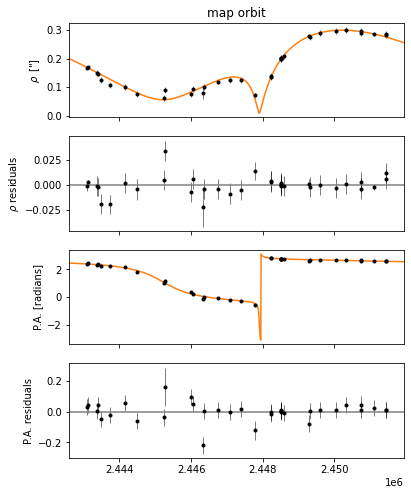

In [10]:
ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(6, 8))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r"$\rho$ residuals")
ax[2].set_ylabel(r"P.A. [radians]")
ax[3].set_ylabel(r"P.A. residuals")

tot_rho_err = np.sqrt(rho_err ** 2 + np.exp(2 * map_soln["log_rho_s"]))
tot_theta_err = np.sqrt(theta_err ** 2 + np.exp(2 * map_soln["log_theta_s"]))

ax[0].errorbar(astro_jds, rho_data, yerr=tot_rho_err, **ekw)
ax[0].plot(t_fine, map_soln["rho_save"], "C1")

ax[1].axhline(0.0, color="0.5")
ax[1].errorbar(
    astro_jds, rho_data - map_soln["rho_model"], yerr=tot_rho_err, **ekw
)


ax[2].plot(t_fine, map_soln["theta_save"], "C1")
ax[2].errorbar(astro_jds, theta_data, yerr=tot_theta_err, **ekw)

ax[3].axhline(0.0, color="0.5")
ax[3].errorbar(
    astro_jds, theta_data - map_soln["theta_model"], yerr=tot_theta_err, **ekw
)

ax[3].set_xlim(t_fine[0], t_fine[-1])
_ = ax[0].set_title("map orbit")

Now let's sample the posterior.

In [11]:
np.random.seed(1234)
with model:
    trace = pmx.sample(
        tune=1000,
        draws=1000,
        start=map_soln,
        cores=2,
        chains=2,
        target_accept=0.9,
        return_inferencedata=True,
    )

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 38 seconds.


First we can check the convergence for some of the key parameters.

In [12]:
import arviz as az

az.summary(
    trace,
    var_names=["P", "tperi", "a_ang", "omega", "Omega", "incl", "ecc"],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
P,10437.389,144.210,10199.842,10713.487,3.944,2.800,1337.0,1327.0,1507.0,1231.0,1.0
tperi,2447860.280,19.953,2447821.322,2447895.249,0.470,0.332,1804.0,1804.0,1813.0,1592.0,1.0
a_ang,0.318,0.008,0.304,0.333,0.000,0.000,1494.0,1482.0,1551.0,1263.0,1.0
omega,1.235,0.014,1.208,1.263,0.000,0.000,1542.0,1539.0,1554.0,1287.0,1.0
Omega,2.787,0.011,2.767,2.808,0.000,0.000,1732.0,1732.0,1743.0,1356.0,1.0
incl,1.691,0.006,1.679,1.702,0.000,0.000,1467.0,1467.0,1482.0,1336.0,1.0
ecc,0.777,0.012,0.754,0.799,0.000,0.000,1485.0,1480.0,1506.0,1371.0,1.0


That looks pretty good.
Now here's a corner plot showing the covariances between parameters.

In [13]:
import corner

_ = corner.corner(
    trace, var_names=["P", "tperi", "a_ang", "omega", "Omega", "incl", "ecc"]
)

ValueError: It looks like the parameter(s) in column(s) 0 have no dynamic range. Please provide a `range` argument.

Finally, we can plot the posterior constraints on $\rho$ and $\theta$.
This figure is much like the one for the MAP solution above, but this time the orange is a contour (not a line) showing the 68% credible region for the model.

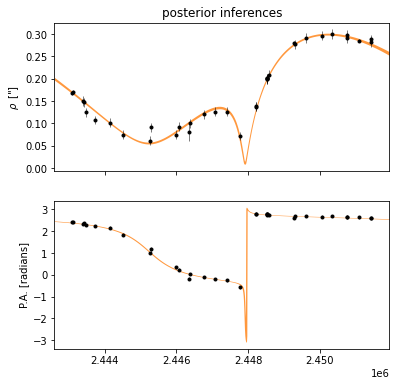

In [14]:
ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r"P.A. [radians]")

tot_rho_err = np.sqrt(
    rho_err ** 2
    + np.exp(2 * np.median(trace.posterior["log_rho_s"].values, axis=(0, 1)))
)
tot_theta_err = np.sqrt(
    theta_err ** 2
    + np.exp(2 * np.median(trace.posterior["log_theta_s"].values, axis=(0, 1)))
)

ax[0].errorbar(astro_jds, rho_data, yerr=tot_rho_err, **ekw)
q = np.percentile(trace.posterior["rho_save"].values, [16, 84], axis=(0, 1))
ax[0].fill_between(t_fine, q[0], q[1], color="C1", alpha=0.8, lw=0)

ax[1].errorbar(astro_jds, theta_data, yerr=tot_theta_err, **ekw)
q = np.percentile(trace.posterior["theta_save"].values, [16, 84], axis=(0, 1))
ax[1].fill_between(t_fine, q[0], q[1], color="C1", alpha=0.8, lw=0)

ax[-1].set_xlim(t_fine[0], t_fine[-1])
_ = ax[0].set_title("posterior inferences")

As we can see from the narrow range of orbits (the orange swath appears like a thin line), the orbit is actually highly constrained by the astrometry.
We also see two outlier epochs in the vicinity of 2445000 - 2447000, since adjacent epochs seem to be right on the orbit.
It's likely the uncertainties were not estimated correctly for these, and the simplistic jitter model we implemented isn't sophisticated to apply more weight to only these discrepant points.

## Including parallax

While this is encouraging that we fit an astrometric orbit, a simple astrometric fit to just $\rho$ and $\theta$ isn't actually that physically satisfying, since many of the orbital parameters simply have to do with the orientation relative to us ($i$, $\omega$, and $\Omega$). The only truly intrinsic parameters are $P$ and $e$. To learn more about some of the physical parameters, such as the total mass of the system, we'd like to incorporate distance information to put a physical scale to the problem.

The *Gaia* DR2 parallax is $\varpi = 24.05 \pm 0.45$ mas.

We can use exactly the same model as above with only an added parallax constraint:

In [15]:
plx_model, plx_map_soln = get_model(parallax=[24.05, 0.45])

optimizing logp for variables: [log_theta_s, log_rho_s]


message: Optimization terminated successfully.
logp: 109.47273175941169 -> 151.57876453514592
optimizing logp for variables: [phase]


message: Optimization terminated successfully.
logp: 151.57876453514592 -> 172.07146119092567
optimizing logp for variables: [ecc, m, p]


message: Optimization terminated successfully.
logp: 172.07146119092567 -> 214.46503864638646
optimizing logp for variables: [phase, a_ang, logP]


message: Optimization terminated successfully.
logp: 214.46503864638646 -> 214.91799361172022
optimizing logp for variables: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang, m_plx]


message: Desired error not necessarily achieved due to precision loss.
logp: 214.91799361172022 -> 219.15808192043994


In [16]:
np.random.seed(5432)
with plx_model:
    plx_trace = pmx.sample(
        tune=1000,
        draws=1000,
        start=plx_map_soln,
        cores=2,
        chains=2,
        target_accept=0.9,
        return_inferencedata=True,
    )

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang, m_plx]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 30 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Check the convergence diagnostics.

In [17]:
az.summary(
    plx_trace,
    var_names=[
        "P",
        "tperi",
        "a_ang",
        "omega",
        "Omega",
        "incl",
        "ecc",
        "M_tot",
        "plx",
    ],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
P,10438.672,142.647,10196.545,10711.466,3.986,2.831,1281.0,1270.0,1517.0,1038.0,1.0
tperi,2447859.730,20.484,2447817.842,2447895.243,0.472,0.334,1882.0,1882.0,1906.0,1610.0,1.0
a_ang,0.318,0.008,0.304,0.334,0.000,0.000,1443.0,1432.0,1428.0,1435.0,1.0
omega,1.235,0.014,1.207,1.260,0.000,0.000,1480.0,1480.0,1472.0,1437.0,1.0
Omega,2.787,0.012,2.766,2.809,0.000,0.000,1731.0,1731.0,1732.0,1223.0,1.0
incl,1.691,0.006,1.679,1.703,0.000,0.000,1164.0,1163.0,1161.0,1172.0,1.0
ecc,0.778,0.013,0.754,0.802,0.000,0.000,1327.0,1323.0,1360.0,1295.0,1.0
M_tot,2.847,0.268,2.375,3.372,0.007,0.005,1475.0,1464.0,1486.0,1505.0,1.0
plx,0.024,0.000,0.023,0.025,0.000,0.000,1878.0,1878.0,1906.0,1265.0,1.0


And make the corner plot for the physical parameters.

In [18]:
_ = corner.corner(plx_trace, var_names=["P", "tperi", "a", "ecc", "M_tot"])

ValueError: It looks like the parameter(s) in column(s) 0 have no dynamic range. Please provide a `range` argument.

## Citations

As described in the [citation tutorial](https://docs.exoplanet.codes/en/stable/tutorials/citation/), we can use [citations.get_citations_for_model](https://docs.exoplanet.codes/en/stable/user/api/#exoplanet.citations.get_citations_for_model) to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [ ]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

In [ ]:
print(bib.split("\n\n")[0] + "\n\n...")